# Neural translation - seq2seq
## French questions to english questions

**Difficulties:**

1. Output of arbitrary length
1. Order of tokens in the input and the output is not the same

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

## Dataset
http://www.statmt.org/wmt15/translation-task.html

Obtained by web crawling millions of sites and using simple heuristics such as replacing *en* with *fr* etc.

In [3]:
PATH = Path('data/translate/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
filename = 'giga-fren.release2.fixed'

In [5]:
en_fn = PATH/f'{filename}.en'
fr_fn = PATH/f'{filename}.fr'

Training a full translation model takes a long time. In this example we therefore focus only on questions that start with *What*, *Where*, *Wh...* etc. and end with a *?*.

Compiling makes the regular expressions faster.

In [6]:
re_enquest = re.compile('^(Wh[^?.!]+\?)')
re_frquest = re.compile('^([^?.!]+\?)')

In [7]:
lines = ((re_enquest.search(enquest), re_frquest.search(frquest)) for enquest, frquest in zip(open(en_fn, encoding='utf-8'), open(fr_fn, encoding='utf-8')))

In [8]:
for i, l in enumerate(lines):
    print(l)
    if i == 20:
        break

(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(<_sre.SRE_Match object; span=(0, 15), match='What is light ?'>, <_sre.SRE_Match object; span=(0, 25), match='Qu’est-ce que la lumière?'>)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, <_sre.SRE_Match object; span=(0, 72), match="Astronomes Introduction Vidéo d'introduction Qu'e>)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(None, None)
(<_sre.SRE_Match object; span=(0, 11), match='Who are we?'>, <_sre.SRE_Match object; span=(0, 15), match='Où sommes-nous?'>)
(<_sre.SRE_Match object; span=(0, 23), match='Where did we come from?'>, <_sre.SRE_Match object; span=(0, 17), match="D'où venons-nous?">)


In [9]:
questions = [(e.group(), f.group()) for e, f in lines if e and f]

In [10]:
pickle.dump(questions, (PATH/'fr-en-questions.pkl').open('wb'))

In [11]:
questions = pickle.load((PATH/'fr-en-questions.pkl').open('rb'))

In [12]:
questions[:3]

[('What would we do without it?', 'Que ferions-nous sans elle ?'),
 ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
  'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?'),
 ('What is the major aboriginal group on Vancouver Island?',
  'Quel est le groupe autochtone principal sur l’île de Vancouver?')]

In [13]:
len(questions)

52328

In [14]:
en_questions, fr_questions = zip(*questions)

### Tokenization

`Tokenizer` is a fastai wrapper around *spacy* that uses multiple processors for speedup.

In [15]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_questions))

In [16]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_questions), 'fr')

In [17]:
en_tok[0]

['what', 'would', 'we', 'do', 'without', 'it', '?']

In [18]:
fr_tok[0]

['que', 'ferions', '-', 'nous', 'sans', 'elle', '?']

#### Average length of the questions

In [19]:
np.mean([len(q) for q in en_tok])

13.345895123069868

In [20]:
np.mean([len(q) for q in fr_tok])

16.26809738572084

#### Discard questions that are too long

In [21]:
keep = np.array([len(q) < 30 for q in en_tok])

In [22]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [23]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [24]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

### Numericalization

In [25]:
def toks2idxs(tok, pre):
    freq = Counter(t for q in tok for t in q)
    itos = [s for s, c in freq.most_common(40000)]
    itos.insert(0, '_bos_')  # beginning of sequence token
    itos.insert(1, '_pad_')  # padding token
    itos.insert(2, '_eos_')  # end of sequence token
    itos.insert(3, '_unk_')  # unknown token
    stoi = collections.defaultdict(lambda: 3, {t:i for i,t in enumerate(itos)})  # if string not found, set to '_unk_'
    indcs = np.array([([stoi[t] for t in q] + [2]) for q in tok])
    np.save(TMP_PATH/f'{pre}_indcs.npy', indcs)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos_pkl', 'wb'))
    return indcs, itos, stoi

In [26]:
en_indcs, en_itos, fr_stoi = toks2idxs(en_tok, 'en')

In [27]:
fr_indcs, fr_itos, fr_stoi = toks2idxs(fr_tok, 'fr')

In [28]:
def load_indcs(pre):
    indcs = np.load(TMP_PATH/f'{pre}_indcs.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos_pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {t:i for i,t in enumerate(itos)})
    return indcs, itos, stoi

In [29]:
en_indcs, en_itos, en_stoi = load_indcs('en')
fr_indcs, fr_itos, fr_stoi = load_indcs('fr')

In [30]:
' '.join([en_itos[i] for i in en_indcs[0]])

'what would we do without it ? _eos_'

In [31]:
' '.join([fr_itos[i] for i in fr_indcs[0]])

'que ferions - nous sans elle ? _eos_'

### Word vectors

In [32]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [33]:
import fastText as ft

In [34]:
en_vecs = ft.load_model(str((PATH/'word_vectors'/'wiki.en.bin')))

In [35]:
fr_vecs = ft.load_model(str(PATH/'word_vectors'/'wiki.fr.bin'))

In [36]:
def get_vecs(lang, ft_vecs):
    vec_dict = {w: ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vec_dict, open(PATH/f'wiki.{lang}.pkl', 'wb'))
    return vec_dict

In [37]:
en_vec_dict = get_vecs('en', en_vecs)
fr_vec_dict = get_vecs('fr', fr_vecs)

In [38]:
en_vec_dict = pickle.load(open(PATH/'wiki.en.pkl','rb'))
en_vec_dict = pickle.load(open(PATH/'wiki.en.pkl','rb'))

In [39]:
ft_words = en_vecs.get_words(include_freq=True)

In [40]:
ft_word_dict = {k:v for k,v in zip(*ft_words)}

In [41]:
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])  # sorted by frequency

In [42]:
ft_words[-20:]

['by',
 'as',
 'for',
 's',
 'on',
 'was',
 'is',
 'a',
 'to',
 '(',
 ')',
 "'",
 'and',
 'in',
 '-',
 'of',
 '</s>',
 'the',
 '.',
 ',']

In [43]:
len(ft_words)

2519370

#### Dimensionality of the word vectors

In [44]:
dim_en_vec = len(en_vec_dict['and'])
dim_fr_vec = len(fr_vec_dict['and'])

In [45]:
dim_en_vec, dim_fr_vec

(300, 300)

#### Mean and stdv of word vectors

In [46]:
en_vecs = np.stack(list(en_vec_dict.values()))
# keys are words, values are the vectors of size 300

In [47]:
en_vecs.shape

(2519370, 300)

In [48]:
en_vecs.mean(), en_vecs.std()

(0.0075652334, 0.29283327)

### Model data object

`en_indcs` are the numericalized questions.

**Percentile:**
*Ist beispielsweise eine Stichprobe von Schuhgrößen gegeben, so ist das empirische 0,35-Quantil diejenige Schuhgröße s , so dass 35 % der Schuhgrößen in der Stichprobe kleiner als s  sind und 65 % größer als s sind.* [source](https://de.wikipedia.org/wiki/Empirisches_Quantil)

In [49]:
en_len_99 = int(np.percentile([len(o) for o in en_indcs], 99))
fr_len_97 = int(np.percentile([len(o) for o in fr_indcs], 97))

In [50]:
en_len_99, fr_len_97

(29, 33)

#### Truncate the questions

In [51]:
en_indcs_trunc = np.array([q[:en_len_99] for q in en_indcs])
fr_indcs_trunc = np.array([q[:fr_len_97] for q in fr_indcs])

A `Dataset` object needs a `__getitem__` and a `__len__` method. This example is actually very general and can be used for any arrays...

In [52]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __getitem__(self, idx):
        return A(self.x[idx], self.y[idx])
    def __len__(self):
        return len(self.x)

In [53]:
??A()  # returns a np.array if len == 1 else returns a list of np.arrays

In [54]:
np.random.seed(42)

#### Split into train and validation set

In [55]:
trn_keep = np.random.rand(len(en_indcs_trunc)) > 0.1

In [56]:
en_trn, fr_trn = en_indcs_trunc[trn_keep], fr_indcs_trunc[trn_keep]

In [57]:
en_val, fr_val = en_indcs_trunc[~trn_keep], fr_indcs_trunc[~trn_keep]  # tilde negates

In [58]:
len(en_trn), len(en_val)

(45218, 5039)

#### Create datasets for french to english translation. Swap arguments to create a english to french model.

In [59]:
trn_ds = Seq2SeqDataset(fr_trn, en_trn)
val_ds = Seq2SeqDataset(fr_val, en_val)

In [60]:
' '.join([fr_itos[o] for o in fr_trn[0]])

'que ferions - nous sans elle ? _eos_'

In [61]:
' '.join([en_itos[o] for o in en_trn[0]])

'what would we do without it ? _eos_'

Everything still looking as expected :)

In [62]:
bs = 125

Since we want to fully utilize the GPUs capabilities, we train in batches. The length of a minibatch tensor is set by the sequence length of the longest question in that batch. The other questions are padded. To save time and memory, we want to avoid very long and very short questions in one batch because that would mean lot's of padding. For the validation set we simply sort the questions. For training we use the `SortishSampler` which groups *longer* questions together and *shorter* questions together while preserving some randomness.

For language models it's better to pad before the start of the sequence because we need the final hidden state to predict the next token or for classification...

For sequence to sequence models it is better to pad after the end of the sequence.

In [63]:
trn_sampler = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_sampler = SortSampler(en_val, key=lambda x:len(en_val[x]))

Both samplers simply return indices:

In [64]:
i = next(iter(trn_sampler))

In [65]:
' '.join([en_itos[o] for o in en_trn[i]])

'why do birds live near the ocean ? _eos_'

In [66]:
' '.join([fr_itos[o] for o in fr_trn[i]])

'pourquoi certains oiseaux vivent - ils à proximité de la mer ? _eos_'

In [67]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, pad_idx=1, pre_pad=False, sampler=trn_sampler)


In [68]:
val_dl = DataLoader(val_ds, int(1.5*bs), transpose=True, transpose_y=True, num_workers=1, pad_idx=1, pre_pad=False, sampler=val_sampler)

Reminder: the ModelData object combines the training and validation dataloaders and a path to story temp stuff. When you have a ModelData object you can create a learner and then call `fit`.

In [69]:
modeldata = ModelData(PATH, trn_dl, val_dl)

**Let's look at an example batch:**

In [70]:
it = iter(trn_dl)
its = [next(it) for i in range(3)]

In [71]:
[(len(x), len(y)) for x,y in its]

[(32, 18), (25, 8), (21, 9)]

In [72]:
for x, y in its:
    print(' '.join([fr_itos[o] for o in x[:,0]]))
    print(' '.join([en_itos[o] for o in y[:,0]]))
    print()

en ce qui concerne l’ adhésion des 10 nouveaux états membres , quelle est la proposition correcte ? _eos_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_
which of the following is correct as regards the accession of the 10 new member states ? _eos_

quels stimulateurs de croissance sont autorisés au canada ? _eos_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_
which products are approved in canada ? _eos_

qui a -t -on atteint avec le programme ? _eos_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_ _pad_
who has been reached by the program ? _eos_



## First model

In [80]:
n_hid, n_layers = 256, 2

In [79]:
def create_emb(wordvecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    weights = emb.weight.data
    not_found = []
    for idx, word in enumerate(itos):
        try:
            weights[idx] = torch.from_numpy(wordvecs[word] * 3)  # wordvecs is a dict
            # wordvecs have stdv of ~0.3, embedding of 1, the found and not found ones should have same stdv
        except:
            not_found.append(word)
    print(len(not_found), not_found[5:10])
    return emb

In [114]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, emb_sz_enc, vecs_dec, itos_dec, emb_sz_dec, nh, out_seqlen, nl=2):
        super().__init__()
        self.nh, self.nl, self.out_seqlen = nh, nl, out_seqlen
        
        # Encoder
        self.emb_enc = create_emb(vecs_enc, itos_enc, emb_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz_enc, nh, num_layers=nl, dropout=0.25)  # sz 300 in, sz 256 out
        self.outp_enc = nn.Linear(nh, emb_sz_dec, bias=False)               # sz 256 in, sz 300 out
        
        # Decoder
        self.emb_dec = create_emb(vecs_dec, itos_dec, emb_sz_dec)
        self.rnn_dec = nn.GRU(emb_sz_dec, emb_sz_dec, num_layers=nl, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)                                           # sz 300 in, 300 out
        self.out = nn.Linear(emb_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data                            # weight tying! not transposed?
        
    def forward(self, inp):
        seqlen, bs = inp.size()
        
        # Encoder
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_outp, h = self.rnn_enc(emb, h)
        # pdb.set_trace()
        h = self.outp_enc(h)  # h[1] is same as enc_outp[-1]!

        # Decoder
        dec_inp = V(torch.zeros(bs).long())  # 0 is 'beginning of seq' token
        res = []
        for i in range(self.out_seqlen):
            emb = self.emb_dec(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
            outp, h = self.rnn_dec(emb, h)  # 'loops' once
            outp = self.out(self.out_drop(outp[0]))  # 0 because 'loops' once, predictions for words
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  # [1] to get argmax
            if (dec_inp == 1).all(): break    # if all sentences in the minibatch have _pad_ as input, break
        return torch.stack(res)
        
    def initHidden(self, bs):
        return V(torch.zeros(self.nl, bs, self.nh))

**Decoder:** `outp`is the same as `h[1]` (has two layers)
```
p outp.shape
torch.Size([1, 187, 300])

p h.shape
torch.Size([2, 187, 300])
```

**Encoder:**
```
p enc_outp.shape
torch.Size([33, 187, 256])

p h.shape
torch.Size([2, 187, 256])
```

`enc_outp[-1]` and `h[1]` are the same

(187 is bs)

### Loss function

In [92]:
def Seq2SeqLoss(pred, target):
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    return F.cross_entropy(pred.view(-1, n_probs), target.view(-1))

In [83]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))  # like bind in c++

In [85]:
dim_fr_vec, dim_en_vec

(300, 300)

In [115]:
rnn = Seq2SeqRNN(fr_vec_dict, fr_itos, dim_fr_vec, en_vec_dict, en_itos, dim_en_vec, n_hid, en_len_99)

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


#### It's kind of understandable that these tokens where not found in the word vectors we downloaded

In [116]:
learn = Learner(modeldata, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)  # SingleModel makes the model one layer group

In [117]:
learn.crit = Seq2SeqLoss

In [94]:
learn.lr_find()

 67%|██████▋   | 241/362 [00:23<00:12, 10.06it/s, loss=37.1]

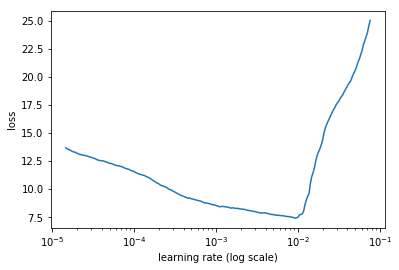

In [95]:
learn.sched.plot()

In [96]:
lr = 3e-3

In [97]:
learn.fit(lr, n_cycle=1, cycle_len=12, use_clr=(20, 10))

 14%|█▍        | 52/362 [00:05<00:30, 10.00it/s, loss=8.32]
epoch      trn_loss   val_loss                              
    0      5.44016    5.701974  
    1      4.310874   4.549533                              
    2      3.890306   4.157954                              
    3      3.719702   4.019643                              
    4      3.322341   3.865383                              
    5      3.221692   3.795207                              
    6      3.220406   3.697457                              
    7      3.244708   3.7222                                
    8      2.893455   3.646579                              
    9      2.846069   3.616925                              
    10     2.784473   3.573879                              
    11     2.667841   3.572502                              



[3.572502047460784]

In [98]:
learn.save('first_model')

In [118]:
learn.load('first_model')

### Test the model

In [145]:
import itertools

In [163]:
x, y = next(itertools.islice(iter(val_dl), 25, None))
probs = learn.model(V(x))

In [164]:
probs.shape

torch.Size([18, 187, 17573])

In [165]:
preds = to_np(probs.max(2)[1])

In [167]:
start = 110
for i in range(start, start + 10):
    print(' '.join([fr_itos[o] for o in x[:, i] if o != 1]))  # Input
    print(' '.join([en_itos[o] for o in y[:, i] if o != 1]))  # Target
    print(' '.join([en_itos[o] for o in preds[:, i] if o != 1]))  # Prediction
    print()

qu' est ce que l ' t_up ipv ? _eos_
what is t_up api ? _eos_
what is the t_up ? _eos_

qu' entend - on par autres méthodes de déclaration ? _eos_
what is alternate reporting ? _eos_
what are other other ? ? _eos_

que montrent - elles ? _eos_
what does it show ? _eos_
what do they do ? _eos_

qui est en conflit ? _eos_
who is in conflict ? _eos_
who is conflict ? _eos_

pourquoi encourager davantage la recherche ? _eos_
why encourage more research ? _eos_
why encourage more promote research ? _eos_

qui sont les vulnérables ? _eos_
who are the vulnerable ? _eos_
who are vulnerable ? ?

pourquoi encourager davantage la recherché ? _eos_
why encourage more research ? _eos_
why encourage we more ? _eos_ _eos_

qu’ est -ce que des données identifiables ? _eos_
what is identifiable data ? _eos_
what is the ? ? _eos_

pourquoi était - il l' adversaire de sir john ? _eos_
why were they opponents ? _eos_
why was he shoemaker ’s ? ? _eos_

qu' est -ce que l' admissibilité partagée ? _eos_
what 